# Sentiments Analysis
## Based on comments
Data Source: https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences

#### 1) Opening the data from files

In [1]:
files_folder = './data/'
files_paths = [files_folder + i for i in ['amazon_cells_labelled.txt', 'imdb_labelled.txt', 'yelp_labelled.txt']]

#### 2) Putting the file data into lists

In [2]:
positive_reviews = []
negative_reviews = []

for file_path in files_paths:
    file = open(file_path, 'r')
    for line in file:
        suffix = -3
        if file_path == './data/imdb_labelled.txt':
            suffix = -5
        
        if int(line[-2]):
            line = line[:suffix]
            positive_reviews.append(line)
        else:
            line = line[:suffix]
            negative_reviews.append(line)

#### 3) Doing permutations

##### Calling library function

In [3]:
from itertools import permutations

##### Positive

In [4]:
positive_reviews_permutations = []

for i in range(2):
    permutations_list = [" ".join(k) for k in permutations(positive_reviews, i+1)]
    positive_reviews_permutations += permutations_list

del positive_reviews

##### Negative

In [5]:
negative_reviews_permutations = []

for i in range(2):
    permutations_list = [" ".join(k) for k in permutations(negative_reviews, i+1)]
    negative_reviews_permutations += permutations_list

del negative_reviews

#### 4) Building the databases (Train/Test)

##### Import library

In [6]:
import pandas as pd

##### Process

In [7]:
sentiments_dict = {
    'review': positive_reviews_permutations + negative_reviews_permutations,
    'approval': [1 for i in positive_reviews_permutations] + [0 for i in negative_reviews_permutations]
}

df = pd.DataFrame(sentiments_dict)
del sentiments_dict, positive_reviews_permutations, negative_reviews_permutations

In [8]:
df['approval'].value_counts()

approval
1    2250000
0    2250000
Name: count, dtype: int64

#### 5) Clear texts

##### Importing library function

In [9]:
from re import sub

##### Clear function

In [10]:
def clean_text(text):
    return text.lower()

##### Process

In [11]:
df['clean_review'] = df['review'].apply(clean_text)
df[['review', 'clean_review']].sample(3)

,review,clean_review
929151,There is a lot of beautiful places. This isn't...,there is a lot of beautiful places. this isn't...
4300012,"I do love sushi, but I found Kabuki to be over...","i do love sushi, but i found kabuki to be over..."
4161713,I will not return. Phone falls out easily.,i will not return. phone falls out easily.


#### 6) Stop Words Removal

##### Importing libraries

In [12]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/stnz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/stnz/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/stnz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##### Set up

In [13]:
usefull_words = {"no", "nor", "not", "don'", "don't", "ain", "aren", "aren't", 
                 "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't",
                 "hadn", "hadn't", "hasn", "hasn't", "haven't", "isn", "isn't",
                 "mightn", "mightn't", "mustn", "mustn't", "needn", "needn't",
                 "shan", "shan't", "shan't", "shouldn", "shouldn't", "wasn",
                 "wasn't", "weren", "weren't", "won't", "wouldn", "wouldn't"}

stop_words = set([w for w in stopwords.words('english') if w not in usefull_words])

In [14]:
def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    return " ".join([word for word in words if word not in stop_words])

##### Process

In [15]:
df['no_stopwords'] = df['clean_review'].apply(remove_stopwords)

In [16]:
df[['clean_review', 'no_stopwords']].sample(3)

,clean_review,no_stopwords
2359078,"after 3 months, screen just went black all of ...","3 months , screen went black sudden . everythi..."
1736851,i would definitely recommend the wings as well...,would definitely recommend wings well pizza . ...
2058428,and the chef was generous with his time (even ...,chef generous time ( even came around twice ta...


#### 7) Stemming

I chose stemming beacuse it's computacional complexity is lower than lemming, 
taking into count that there are many instances of training because of the
permutations done to the original data.

##### Importing libraries

In [17]:
from nltk.stem import PorterStemmer

##### Set up

In [18]:
def stem(text):
    words = nltk.word_tokenize(text)
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in words])    

##### Process

In [19]:
df['stemmed'] = df['no_stopwords'].apply(stem)

In [20]:
df[['no_stopwords', 'stemmed']].sample(3)

,no_stopwords,stemmed
1401696,saw short film hbo day absolutely loved . love...,saw short film hbo day absolut love . love fea...
2596587,disappointment . charger arrived within promis...,disappoint . charger arriv within promis timef...
2854398,three broke within two months use . not buy no...,three broke within two month use . not buy not...


#### 8) Bag Of Words

This method is ideal for short text (such as the ones used here).
Also it has a lower computing complexity when compared to the TF-IDF.

##### Importing library function

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

##### Process

In [23]:
cv = CountVectorizer()
X = cv.fit_transform(df['stemmed'])

#### 9) Divide Data (Train/Test)

##### Importing libraries function

In [24]:
from sklearn.model_selection import train_test_split

##### Process

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, df['approval'], random_state=777)

#### 10) Naive Bayes

##### Importing libraries function

In [26]:
from sklearn.naive_bayes import MultinomialNB

##### Train

In [27]:
classifier = MultinomialNB()
classifier.fit(X_train, Y_train)

MultinomialNB()

##### Predict

In [28]:
Y_prediction = classifier.predict(X_test)

#### 11) Results

##### Importing libraries

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt

##### Plotting

##### Table

In [38]:
print("Classification Report:")
print(classification_report(Y_test, Y_prediction))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    562531
           1       1.00      0.99      0.99    562469

    accuracy                           0.99   1125000
   macro avg       0.99      0.99      0.99   1125000
weighted avg       0.99      0.99      0.99   1125000



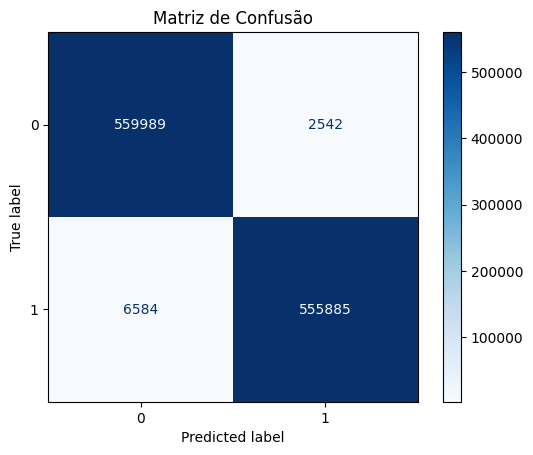

In [33]:
conf_matrix = confusion_matrix(Y_test, Y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()